In [1]:
import os, sys
import copy
from collections import Counter
from datetime import datetime

sys.path.append('../src/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import data.dataset as dtst
import features.preprocessing as prep
import visualization.visualize as vis
import models.evaluate_model as evl

c:\users\weldl\miniconda3\envs\i2a2-fm\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\weldl\miniconda3\envs\i2a2-fm\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\users\weldl\miniconda3\envs\i2a2-fm\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Loading the dataset
folderpath = '../data/processed'
df_train, df_test = dtst.load_stocks_data(folderpath)

In [3]:
df_train

,Date,Open,High,Low,Close,Adj Close,Volume,macd,signal,histogram,...,pref_ema21_perc,pref_ema50_perc,ema9gt21,ema9gt50,ema21gt50,open_close_diff_perc,open_close_diff_ratio,min_max_diff_ratio,y_target,ticker
2000-01-03,2000-01-03,99.724503,100.157043,96.408363,96.840897,71.915710,1291300.0,4.450243,4.348044,0.102199,...,0.054779,0.132978,1,1,1,-0.028916,-0.029777,0.038710,1.0,AA
2000-01-04,2000-01-04,96.840897,97.946281,96.360298,97.561798,72.451111,1859900.0,4.341700,4.346775,-0.005075,...,0.056615,0.135117,1,1,1,0.007444,0.007389,0.016256,2.0,AA
2000-01-05,2000-01-05,97.561798,103.713478,97.321503,103.329002,76.733902,2598000.0,4.667242,4.410869,0.256374,...,0.107091,0.192759,1,1,1,0.059113,0.055814,0.061860,2.0,AA
2000-01-06,2000-01-06,103.329002,103.617363,101.550781,101.598839,75.449089,3740800.0,4.731090,4.474913,0.256177,...,0.079860,0.164894,1,1,1,-0.016744,-0.017029,0.020341,2.0,AA
2000-01-07,2000-01-07,101.598839,104.001839,101.358543,101.406601,75.306320,3774100.0,4.711863,4.522303,0.189560,...,0.070246,0.155319,1,1,1,-0.001892,-0.001896,0.026066,1.0,AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,2020-03-26,10.230000,11.430000,10.230000,11.100000,11.100000,189500.0,-0.252450,-0.125091,-0.127359,...,0.008091,0.022480,0,0,1,0.085044,0.078378,0.108108,2.0,ZYXI
2020-03-27,2020-03-27,10.700000,10.980000,10.060000,10.300000,10.300000,145000.0,-0.272685,-0.154610,-0.118076,...,-0.059041,-0.049303,0,0,1,-0.037383,-0.038835,0.089320,2.0,ZYXI
2020-03-30,2020-03-30,10.160000,11.060000,10.160000,10.800000,10.800000,162300.0,-0.245546,-0.172797,-0.072749,...,-0.012164,-0.003029,0,0,1,0.062992,0.059259,0.083333,2.0,ZYXI
2020-03-31,2020-03-31,10.680000,11.140000,10.590000,11.070000,11.070000,280400.0,-0.199946,-0.178227,-0.021719,...,0.011380,0.021019,0,0,1,0.036517,0.035230,0.049684,1.0,ZYXI


In [4]:
df_test

,Date,Open,High,Low,Close,Adj Close,Volume,macd,signal,histogram,...,pref_ema21_perc,pref_ema50_perc,ema9gt21,ema9gt50,ema21gt50,open_close_diff_perc,open_close_diff_ratio,min_max_diff_ratio,y_target,ticker
2000-01-31,2000-01-31,48.327969,48.372677,46.316166,47.344421,40.718338,1040300.0,2.146637,2.865437,-0.718800,...,0.004712,0.116332,1,1,1,-0.020352,-0.020774,0.043437,1.0,A
2000-02-01,2000-02-01,47.389126,51.502148,47.389126,50.786839,43.678993,1404200.0,2.180930,2.728536,-0.547606,...,0.070199,0.188297,1,1,1,0.071698,0.066901,0.080986,2.0,A
2000-02-02,2000-02-02,51.412731,54.721031,51.189198,54.721031,47.062561,1945100.0,2.496782,2.682185,-0.185403,...,0.137273,0.266425,1,1,1,0.064348,0.060458,0.064543,2.0,A
2000-02-03,2000-02-03,53.782188,55.615166,52.798641,55.615166,47.831566,1779500.0,2.787118,2.703172,0.083947,...,0.139707,0.272787,1,1,1,0.034081,0.032958,0.050643,2.0,A
2000-02-04,2000-02-04,55.615166,55.615166,53.648067,54.542202,46.908756,1145600.0,2.897235,2.741984,0.155251,...,0.105885,0.236198,1,1,1,-0.019293,-0.019672,0.036066,1.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,2020-03-26,6.830000,7.460000,6.640000,7.370000,7.370000,349000.0,-1.255083,-1.218581,-0.036502,...,-0.071352,-0.217503,0,0,0,0.079063,0.073270,0.111262,2.0,ZTR
2020-03-27,2020-03-27,7.040000,7.640000,7.000000,7.470000,7.470000,157400.0,-1.129932,-1.200851,0.070919,...,-0.053697,-0.200399,0,0,0,0.061080,0.057564,0.085676,2.0,ZTR
2020-03-30,2020-03-30,7.370000,7.560000,7.210000,7.390000,7.390000,262700.0,-1.025384,-1.165758,0.140374,...,-0.058367,-0.202426,0,0,0,0.002714,0.002706,0.047361,1.0,ZTR
2020-03-31,2020-03-31,7.180000,7.450000,7.140000,7.200000,7.200000,259800.0,-0.946944,-1.121995,0.175051,...,-0.075638,-0.216079,0,0,0,0.002786,0.002778,0.043056,0.0,ZTR


In [5]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,7305243.0,1.054509e+04,8.243348e+05,1.000000e-03,8.600000,16.670000,33.980000,1.914063e+08
High,7305243.0,1.091766e+04,8.509814e+05,1.000000e-03,8.750000,16.900000,34.439999,1.914063e+08
Low,7305243.0,1.008362e+04,7.889578e+05,1.000000e-03,8.450000,16.430000,33.490002,1.851563e+08
Close,7305243.0,1.046350e+04,8.170202e+05,1.000000e-03,8.600000,16.670000,33.980000,1.875000e+08
Adj Close,7305243.0,1.045824e+04,8.170202e+05,-1.202900e+00,6.121684,12.858480,28.197970,1.875000e+08
Volume,7305243.0,1.400163e+06,7.340627e+06,0.000000e+00,19600.000000,137200.000000,703800.000000,1.855410e+09
macd,7305243.0,-1.778518e+02,4.382090e+04,-9.982415e+06,-0.173774,0.014750,0.243780,1.175848e+07
signal,7305243.0,-1.770724e+02,4.144101e+04,-8.893624e+06,-0.162481,0.014977,0.232655,9.118558e+06
histogram,7305243.0,-7.793700e-01,1.277506e+04,-3.348873e+06,-0.060053,0.000698,0.062878,5.941457e+06
williams_r,7305243.0,-4.832798e+01,3.071390e+01,-1.540000e+03,-75.000000,-47.555584,-21.176497,9.150000e+03


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7305243 entries, 2000-01-03 to 2020-04-01
Data columns (total 34 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Open                   float64
 2   High                   float64
 3   Low                    float64
 4   Close                  float64
 5   Adj Close              float64
 6   Volume                 float64
 7   macd                   float64
 8   signal                 float64
 9   histogram              float64
 10  williams_r             float64
 11  sma9                   float64
 12  sma21                  float64
 13  sma50                  float64
 14  pref_sma9_perc         float64
 15  pref_sma21_perc        float64
 16  pref_sma50_perc        float64
 17  sma9gt21               int32  
 18  sma9gt50               int32  
 19  sma21gt50              int32  
 20  ema9                   float64
 21  ema21                  float64
 22  ema

In [7]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,7586904.0,9.213983e+06,9.181368e+08,2.000000e-03,9.210000,18.389999,36.799999,1.824984e+11
High,7586904.0,9.394641e+06,9.346227e+08,2.000000e-03,9.372500,18.650000,37.310001,1.824984e+11
Low,7586904.0,8.984557e+06,8.956111e+08,1.670000e-03,9.052160,18.110001,36.270000,1.704780e+11
Close,7586904.0,9.174038e+06,9.137684e+08,1.670000e-03,9.210000,18.389999,36.806343,1.735020e+11
Adj Close,7586904.0,9.174032e+06,9.137684e+08,-1.529784e+00,6.401956,14.000000,30.455268,1.735020e+11
Volume,7586904.0,1.314177e+06,2.004650e+07,0.000000e+00,17300.000000,124400.000000,679100.000000,4.483504e+09
macd,7586904.0,-9.319588e+04,3.868763e+07,-1.386699e+10,-0.189418,0.015269,0.259857,1.260268e+10
signal,7586904.0,-8.799935e+04,3.664430e+07,-1.253974e+10,-0.176813,0.015538,0.247893,1.058880e+10
histogram,7586904.0,-5.196528e+03,1.281083e+07,-5.143802e+09,-0.064806,0.000759,0.067672,4.440019e+09
williams_r,7586904.0,-4.840207e+01,3.040703e+01,-1.499999e+02,-75.000025,-47.701151,-21.186452,9.499999e+01


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7586904 entries, 2000-01-31 to 2020-04-01
Data columns (total 34 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Open                   float64
 2   High                   float64
 3   Low                    float64
 4   Close                  float64
 5   Adj Close              float64
 6   Volume                 float64
 7   macd                   float64
 8   signal                 float64
 9   histogram              float64
 10  williams_r             float64
 11  sma9                   float64
 12  sma21                  float64
 13  sma50                  float64
 14  pref_sma9_perc         float64
 15  pref_sma21_perc        float64
 16  pref_sma50_perc        float64
 17  sma9gt21               int32  
 18  sma9gt50               int32  
 19  sma21gt50              int32  
 20  ema9                   float64
 21  ema21                  float64
 22  ema

# Data Exploration


In [9]:
df_train_desc = df_train.describe().transpose()
features_list = list(df_train_desc.index)
df_train_desc

,count,mean,std,min,25%,50%,75%,max
Open,7305243.0,1.054509e+04,8.243348e+05,1.000000e-03,8.600000,16.670000,33.980000,1.914063e+08
High,7305243.0,1.091766e+04,8.509814e+05,1.000000e-03,8.750000,16.900000,34.439999,1.914063e+08
Low,7305243.0,1.008362e+04,7.889578e+05,1.000000e-03,8.450000,16.430000,33.490002,1.851563e+08
Close,7305243.0,1.046350e+04,8.170202e+05,1.000000e-03,8.600000,16.670000,33.980000,1.875000e+08
Adj Close,7305243.0,1.045824e+04,8.170202e+05,-1.202900e+00,6.121684,12.858480,28.197970,1.875000e+08
Volume,7305243.0,1.400163e+06,7.340627e+06,0.000000e+00,19600.000000,137200.000000,703800.000000,1.855410e+09
macd,7305243.0,-1.778518e+02,4.382090e+04,-9.982415e+06,-0.173774,0.014750,0.243780,1.175848e+07
signal,7305243.0,-1.770724e+02,4.144101e+04,-8.893624e+06,-0.162481,0.014977,0.232655,9.118558e+06
histogram,7305243.0,-7.793700e-01,1.277506e+04,-3.348873e+06,-0.060053,0.000698,0.062878,5.941457e+06
williams_r,7305243.0,-4.832798e+01,3.071390e+01,-1.540000e+03,-75.000000,-47.555584,-21.176497,9.150000e+03


In [10]:
# vis.plot_features_hist(df_train, features_list)

# Data Preparation

In [11]:
df_train = df_train[0:100000]

In [12]:
# Useful variables:
Y_TARGET = 'y_target'

df_train[Y_TARGET].value_counts()

2.0    34940
0.0    32898
1.0    32162
Name: y_target, dtype: int64

In [13]:
# Splitting X and y:
y_train = df_train[Y_TARGET]
X_train = df_train.drop(columns=[Y_TARGET])

y_test = df_test[Y_TARGET]
X_test = df_test.drop(columns=[Y_TARGET])

In [14]:
print('Train dataset %s' % Counter(y_train))
print('Test dataset  %s' % Counter(y_test))

Train dataset Counter({2.0: 34940, 0.0: 32898, 1.0: 32162})
Test dataset  Counter({1.0: 2644610, 2.0: 2551487, 0.0: 2390807})


# Preprocessing

In [15]:
df_train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'macd',
       'signal', 'histogram', 'williams_r', 'sma9', 'sma21', 'sma50',
       'pref_sma9_perc', 'pref_sma21_perc', 'pref_sma50_perc', 'sma9gt21',
       'sma9gt50', 'sma21gt50', 'ema9', 'ema21', 'ema50', 'pref_ema9_perc',
       'pref_ema21_perc', 'pref_ema50_perc', 'ema9gt21', 'ema9gt50',
       'ema21gt50', 'open_close_diff_perc', 'open_close_diff_ratio',
       'min_max_diff_ratio', 'y_target', 'ticker'],
      dtype='object')

In [16]:
# Listing all the features by type
numeric_features = ['macd', 'signal', 'histogram', 'williams_r',
                    'pref_sma9_perc', 'pref_sma21_perc', 'pref_sma50_perc',
                    'pref_ema9_perc', 'pref_ema21_perc', 'pref_ema50_perc',
                    'open_close_diff_perc', 'open_close_diff_ratio', 'min_max_diff_ratio',
                   ]
boolean_features = ['sma9gt21', 'sma9gt50','sma21gt50',
                    'ema9gt21', 'ema9gt50', 'ema21gt50',
                   ]
ordinary_features = []
categoric_features = []

print(len(numeric_features + boolean_features + ordinary_features + categoric_features), 'features selected')

19 features selected


In [17]:
# Features encoding
features_encoder = ColumnTransformer([("numeric features", Pipeline([('num imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                                                                     ('num scaling', MinMaxScaler()),
                                                                ]), numeric_features),
                                      ("boolean features", Pipeline([('bool imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                                                ]), boolean_features),
                                     ], remainder='drop')

In [18]:
# Features selection
features_selector = VarianceThreshold(threshold=0)

In [19]:
# Pre-processing pipeline:
preprocessor = Pipeline([('features encoding', copy.deepcopy(features_encoder)),
                         ('features selection', copy.deepcopy(features_selector)),
                        ])

In [20]:
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

In [21]:
pd.DataFrame(X_train_encoded)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.273235,0.239834,0.761715,0.459303,0.124609,0.065510,0.050941,0.211859,0.115063,0.069036,0.342118,0.944178,0.003353,1.0,1.0,1.0,1.0,1.0,1.0
1,0.273225,0.239834,0.761693,0.497793,0.124638,0.065588,0.051043,0.212661,0.115266,0.069168,0.356116,0.947338,0.001408,1.0,1.0,1.0,1.0,1.0,1.0
2,0.273254,0.239840,0.761747,0.617909,0.130331,0.068922,0.053715,0.222043,0.120834,0.072715,0.376007,0.951455,0.005358,1.0,1.0,1.0,1.0,1.0,1.0
3,0.273259,0.239846,0.761747,0.534906,0.127157,0.067256,0.052449,0.216470,0.117830,0.071000,0.346804,0.945262,0.001762,1.0,1.0,1.0,1.0,1.0,1.0
4,0.273258,0.239850,0.761733,0.514499,0.125813,0.066600,0.051959,0.214717,0.116769,0.070411,0.352521,0.946549,0.002258,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.272866,0.239480,0.761694,0.391602,0.124275,0.064602,0.046455,0.212538,0.112842,0.065690,0.348774,0.945710,0.001019,1.0,1.0,1.0,1.0,1.0,1.0
99996,0.272866,0.239480,0.761694,0.391602,0.124109,0.064363,0.046404,0.211929,0.112484,0.065487,0.353250,0.946710,0.000000,1.0,1.0,1.0,1.0,1.0,1.0
99997,0.272871,0.239481,0.761703,0.636354,0.130452,0.067741,0.048994,0.221393,0.118177,0.069000,0.375895,0.951433,0.004812,1.0,1.0,1.0,1.0,1.0,1.0
99998,0.272871,0.239482,0.761701,0.289252,0.125288,0.064905,0.047054,0.212363,0.113305,0.066182,0.338992,0.943440,0.003998,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
pd.DataFrame(X_test_encoded)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.273031,0.239705,0.761545,0.153447,0.119129,0.060617,0.051031,0.204477,0.109540,0.068012,0.345415,0.944944,0.003762,1.0,1.0,1.0,1.0,1.0,1.0
1,0.273034,0.239693,0.761581,0.500959,0.127689,0.065367,0.054248,0.217478,0.116764,0.072440,0.380852,0.952397,0.007015,1.0,1.0,1.0,1.0,1.0,1.0
2,0.273062,0.239689,0.761655,0.636354,0.135827,0.070259,0.057743,0.229087,0.124163,0.077247,0.378022,0.951849,0.005590,1.0,1.0,1.0,1.0,1.0,1.0
3,0.273088,0.239691,0.761711,0.636354,0.136085,0.070855,0.058005,0.227807,0.124432,0.077639,0.366370,0.949512,0.004386,1.0,1.0,1.0,1.0,1.0,1.0
4,0.273097,0.239695,0.761726,0.562928,0.131797,0.068804,0.056168,0.220448,0.120701,0.075387,0.345823,0.945037,0.003124,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7586899,0.272730,0.239349,0.761686,0.310114,0.145108,0.055421,0.031041,0.227984,0.101149,0.047470,0.383687,0.952938,0.009637,0.0,0.0,0.0,0.0,0.0,0.0
7586900,0.272741,0.239351,0.761708,0.334923,0.145762,0.057158,0.031723,0.226456,0.103097,0.048523,0.376764,0.951603,0.007421,0.0,0.0,0.0,0.0,0.0,0.0
7586901,0.272750,0.239354,0.761723,0.341921,0.143014,0.057330,0.031638,0.220949,0.102582,0.048398,0.354295,0.946940,0.004102,0.0,0.0,0.0,0.0,0.0,0.0
7586902,0.272757,0.239358,0.761730,0.408458,0.134200,0.056960,0.031082,0.214036,0.100677,0.047558,0.354322,0.946946,0.003729,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

In [23]:
# Training settings:
n_jobs = 4
n_iter = 100
cv = 10
scoring = 'balanced_accuracy'

X_train_ = X_train_encoded
y_train_ = y_train

In [24]:
# DecisionTreeClassifier:
param_grid = {'criterion': ["gini", "entropy"],
              'max_depth': [3,4,5,8,10,15],
              'min_samples_split': [2,4,6,8,10,15,20],
              'max_features': [3, 5, 8, 10, "auto", "sqrt", "log2"],
             }

tree_clf = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_grid, n_iter=n_iter, cv=cv,
                              scoring=scoring, n_jobs=n_jobs, verbose=1, random_state=42)
tree_clf.fit(X_train_, y_train_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 8, 10, 15],
                                        'max_features': [3, 5, 8, 10, 'auto',
                                                         'sqrt', 'log2'],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              15, 20]},
                   random_state=42, scoring='balanced_accuracy', verbose=1)

In [25]:
# RandomForest:
param_grid = {'n_estimators': [1,3,5,8,10,12,15,20],
              'criterion': ["gini", "entropy"],
              'max_depth': [3,4,5,8,10,15],
              'min_samples_split': [2,4,6,8,10],
              'max_features': [3, 5, 8, 10, "auto", "sqrt", "log2"],
             }

rf_clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=n_iter, cv=cv,
                             scoring=scoring, n_jobs=n_jobs, verbose=1, random_state=42)
rf_clf.fit(X_train_, y_train_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=4,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5, 8, 10, 15],
                                        'max_features': [3, 5, 8, 10, 'auto',
                                                         'sqrt', 'log2'],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': [1, 3, 5, 8, 10, 12, 15,
                                                         20]},
                   random_state=42, scoring='balanced_accuracy', verbose=1)

In [26]:
# # KNeighbors:
# param_grid = {'n_neighbors': [1, 3, 5, 10],
#               'weights': ["uniform", "distance"],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'leaf_size': [3, 5, 8, 10, 20, 30, 40],
#              }

# knn_clf = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_grid, n_iter=n_iter, cv=cv,
#                              scoring=scoring, n_jobs=n_jobs, verbose=1, random_state=42)
# knn_clf.fit(X_train_, y_train_)

In [27]:
# # MLP:
# param_grid = {'hidden_layer_sizes': [4, 8, 16, 32, 64],
#               'activation': ['identity', 'logistic', 'tanh'],
#               'solver': ['lbfgs', 'sgd', 'adam'],
#               'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
#               'learning_rate': ['constant', 'invscaling', 'adaptive'],
#              }

# mlp_clf = RandomizedSearchCV(MLPClassifier(), param_distributions=param_grid, n_iter=n_iter, cv=cv,
#                              scoring=scoring, n_jobs=n_jobs, verbose=1, random_state=42)
# mlp_clf.fit(X_train_, y_train_)

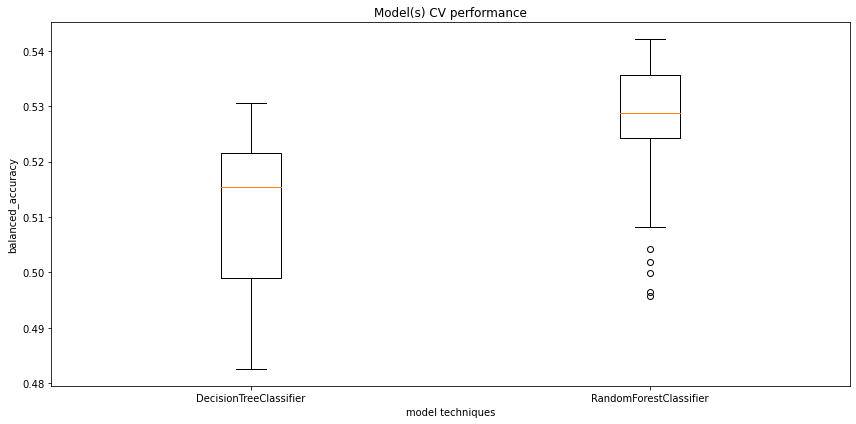

In [28]:
estimators_list = [tree_clf, rf_clf]
evl.plot_estimators_cvperf(estimators_list, error_metric=scoring)

In [29]:
# Selecting the best model and saving it
estimator = estimators_list[np.argmax([pd.DataFrame(m.cv_results_)['mean_test_score'].dropna().max() for m in estimators_list])].best_estimator_
estimator.fit(X_train_, y_train_)

model = Pipeline([('preprocessor', copy.deepcopy(preprocessor)),
                  ('estimator', estimator),
                 ])

In [30]:
from joblib import dump, load

modelpath = '../models/model_enhanced_v2.joblib'
dump(model, modelpath) 

['../models/model_enhanced_v2.joblib']

# Model Evaluation

In [31]:
model = load(modelpath)

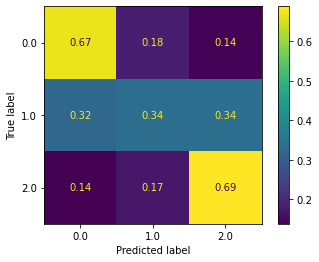

In [32]:
plot_confusion_matrix(model, X_train, y_train, cmap='viridis', normalize='true')
plt.show()

In [33]:
print(classification_report(y_train_, model.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.59      0.67      0.63     32898
         1.0       0.47      0.34      0.39     32162
         2.0       0.61      0.69      0.64     34940

    accuracy                           0.57    100000
   macro avg       0.56      0.57      0.56    100000
weighted avg       0.56      0.57      0.56    100000



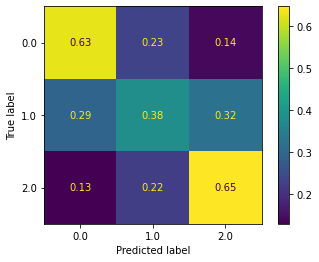

In [34]:
plot_confusion_matrix(model, X_test, y_test, cmap='viridis', normalize='true')
plt.show()

In [35]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.58      0.63      0.60   2390807
         1.0       0.47      0.38      0.42   2644610
         2.0       0.58      0.65      0.61   2551487

    accuracy                           0.55   7586904
   macro avg       0.54      0.55      0.55   7586904
weighted avg       0.54      0.55      0.54   7586904

